In [ ]:
!git clone https://github.com/sharmahr/Text-to-Face-Composition.git 
#Rename to T2F or from drive

Cloning into 'Text-to-Face-Composition'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 77 (delta 0), reused 0 (delta 0), pack-reused 74
Unpacking objects: 100% (77/77), done.


In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!mkdir /content/T2F/implementation/networks/InferSent/models

In [ ]:
!curl -Lo /content/T2F/implementation/networks/InferSent/models/infersent2.pkl https://dl.fbaipublicfiles.com/infersent/infersent2.pkl

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  146M  100  146M    0     0  62.8M      0  0:00:02  0:00:02 --:--:-- 62.8M


In [ ]:
'''
!wget http://nlp.stanford.edu/data/glove.840B.300d.zip
!unzip glove.840B.300d.zip
!mv glove.840B.300d.txt /content/T2F/implementation/networks/InferSent/models/glove.840B.300d.txt
!cp /content/T2F/implementation/networks/InferSent/models/glove.840B.300d.txt /content/gdrive/MyDrive/major
!cp -r T2F gdrive/MyDrive/major
!cp /content/T2F/implementation/networks/InferSent/models/infersent2.pkl /content/gdrive/MyDrive/major
!pip install -r T2F/requirements.txt
'''

In [ ]:
!wget http://vis-www.cs.umass.edu/lfw/lfw.tgz
!tar -xf lfw.tgz

--2021-01-21 09:11:40--  http://vis-www.cs.umass.edu/lfw/lfw.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180566744 (172M) [application/x-gzip]
Saving to: ‘lfw.tgz’

lfw.tgz             100%[===================>] 172.20M  36.3MB/s    in 6.2s    

2021-01-21 09:11:47 (28.0 MB/s) - ‘lfw.tgz’ saved [180566744/180566744]



In [ ]:
!pip install tensorflow==1.7.0

     |████████████████████████████████| 48.0MB 66kB/s 
     |████████████████████████████████| 3.1MB 54.9MB/s 
     |████████████████████████████████| 890kB 26.0MB/s 
  Created wheel for html5lib: filename=html5lib-0.9999999-cp36-none-any.whl size=107222 sha256=6ea42d323b3bc8109f35a1bf2e43849d73b30c6e9a98450ff28976453c5cd141
  Stored in directory: /root/.cache/pip/wheels/50/ae/f9/d2b189788efcf61d1ee0e36045476735c838898eef1cad6e29
Successfully built html5lib
  Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Found existing installation: bleach 3.2.1
    Uninstalling bleach-3.2.1:
      Successfully uninstalled bleach-3.2.1
  Found existing installation: tensorboard 2.4.0
    Uninstalling tensorboard-2.4.0:
      Successfully uninstalled tensorboard-2.4.0
  Found existing installation: tensorflow 2.4.0
    Uninstalling tensorflow-2.4.0:
      Successfully uninstalled tensorflow-2.4.0


In [ ]:
!pip install numpy
!pip install PyYAML
!pip install easydict

In [ ]:
!pip install torch==0.4.0
!pip install torchvision==0.2.1

In [ ]:
!pip uninstall -y torch
!pip install https://download.pytorch.org/whl/cu100/torch-1.0.0-cp36-cp36m-linux_x86_64.whl

Uninstalling torch-0.4.0:
  Successfully uninstalled torch-0.4.0
     |████████████████████████████████| 753.6MB 24kB/s 


In [ ]:
# !pip install Pillow
# !pip3 install torchvision>=0.5.0
# !pip3 install -U git+https://github.com/pytorch/vision

In [ ]:
!pip3 install "pillow<7"

In [ ]:
import sys
sys.path.append('/content/T2F/implementation')
sys.path.append('/content/T2F/')

In [ ]:
from train_network import main as main_train
from train_network import get_config

import argparse

parser = argparse.ArgumentParser()
parser.add_argument("--config", action="store", type=str, default="/content/gdrive/MyDrive/major/config.conf",
                    help="default configuration for the Network")
parser.add_argument("--start_depth", action="store", type=int, default=0,
                    help="Starting depth for training the network")
parser.add_argument("--encoder_file", action="store", type=str, default=None,
                    help="pretrained Encoder file (compatible with my code)")
parser.add_argument("--ca_file", action="store", type=str, default=None,
                    help="pretrained Conditioning Augmentor file (compatible with my code)")
parser.add_argument("--generator_file", action="store", type=str, default=None,
                    help="pretrained Generator file (compatible with my code)")
parser.add_argument("--discriminator_file", action="store", type=str, default=None,
                    help="pretrained Discriminator file (compatible with my code)")

args = parser.parse_args([])
config = get_config(args.config)

In [ ]:
import torch as th

class ConditionAugmentor(th.nn.Module):
    """ Perform conditioning augmentation
        from the paper -> https://arxiv.org/abs/1710.10916 (StackGAN++)
        uses the reparameterization trick from VAE paper.
    """

    def __init__(self, input_size, latent_size, use_eql=True, device=th.device("cpu")):
        """
        constructor of the class
        :param input_size: input size to the augmentor
        :param latent_size: required output size
        :param use_eql: boolean for whether to use equalized learning rate
        :param device: device on which to run the Module
        """
        super(ConditionAugmentor, self).__init__()

        assert latent_size % 2 == 0, "Latent manifold has odd number of dimensions"

        # state of the object
        self.device = device
        self.input_size = input_size
        self.latent_size = latent_size

        # required modules:
        if use_eql:
            from pro_gan_pytorch.CustomLayers import _equalized_linear
            self.transformer = _equalized_linear(self.input_size, 2 * self.latent_size).to(device)
        else:
            self.transformer = th.nn.Linear(self.input_size, 2 * self.latent_size).to(device)

    def forward(self, x, epsilon=1e-12):
        """
        forward pass (computations)
        :param x: input
        :param epsilon: a small noise added for numerical stability
        :return: c_not_hat, mus, sigmas => augmented text embeddings, means, stds
        """
        from torch.nn.functional import relu

        # apply the feed forward layer:
        combined = self.transformer(x)

        # use the reparameterization trick
        mid_point = self.latent_size
        mus, sigmas = combined[:, :mid_point], combined[:, mid_point:]

        # mus don't need to be transformed, but sigmas cannot be negative.
        # so, we'll apply a ReLU on top of sigmas
        sigmas = relu(sigmas)  # hopefully the network will learn a good sigma mapping
        sigmas = sigmas + epsilon  # small noise added for stability

        epsilon = th.randn(*mus.shape).to(self.device)
        c_not_hat = (epsilon * sigmas) + mus

        return c_not_hat, mus, sigmas

In [ ]:
device = 'cuda'

import data_processing.DataLoader as dl

dataset = dl.RawTextFace2TextDataset(
    annots_file=config.annotations_file,
    img_dir=config.images_dir,
    img_transform=dl.get_transform(config.img_dims)
)


In [ ]:
from networks.TextEncoder import PretrainedEncoder
# create a new session object for the pretrained encoder:
text_encoder = PretrainedEncoder(
    model_file=config.pretrained_encoder_file,
    embedding_file=config.pretrained_embedding_file,
    device=device
)

Vocab size : 300000


In [ ]:
# text_encoder = PretrainedEncoder(
#     model_file=config.pretrained_encoder_file,
#     embedding_file=config.pretrained_embedding_file,
#     device=device
# )

In [ ]:
condition_augmenter = ConditionAugmentor(
    input_size=config.hidden_size,
    latent_size=config.ca_out_size,
    use_eql=config.use_eql,
    device='cuda'
)

In [ ]:
temp_data = dl.get_data_loader(dataset, 64, num_workers=3)
fixed_captions, fixed_real_images = iter(temp_data).next()
fixed_embeddings = text_encoder(fixed_captions)
fixed_embeddings.shape

/content/T2F/implementation/networks/InferSent/models.py:210: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  sentences = np.array(sentences)[idx_sort]


(64, 4096)

In [ ]:
condition_augmenter.train()

# create fixed_input for debugging
temp_data = dl.get_data_loader(dataset, 64, num_workers=3)
fixed_captions, fixed_real_images = iter(temp_data).next()
fixed_embeddings = text_encoder(fixed_captions)
fixed_embeddings = th.from_numpy(fixed_embeddings).to(device)

fixed_c_not_hats, _, _ = condition_augmenter(fixed_embeddings)

fixed_noise = th.randn(len(fixed_captions),
                       config.latent_size - fixed_c_not_hats.shape[-1]).to(device)

fixed_gan_input = th.cat((fixed_c_not_hats, fixed_noise), dim=-1)

/content/T2F/implementation/networks/InferSent/models.py:210: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  sentences = np.array(sentences)[idx_sort]


In [ ]:
fixed_embeddings.shape

torch.Size([64, 4096])

In [ ]:
import torch
torch.load('/content/T2F/implementation/networks/InferSent/models/infersent2.pkl')

OrderedDict([('enc_lstm.weight_ih_l0',
              tensor([[-0.0188, -0.0096, -0.0165,  ...,  0.0063,  0.0177,  0.0182],
                      [ 0.0040, -0.0170,  0.0282,  ...,  0.0270, -0.0006, -0.0099],
                      [-0.0333,  0.0013,  0.0235,  ...,  0.0239, -0.0444,  0.0009],
                      ...,
                      [ 0.0068, -0.0130, -0.0136,  ..., -0.0003,  0.0145, -0.0031],
                      [-0.0075, -0.0210,  0.0135,  ...,  0.0149, -0.0059,  0.0018],
                      [-0.0076,  0.0241, -0.0258,  ..., -0.0104,  0.0177,  0.0241]])),
             ('enc_lstm.weight_hh_l0',
              tensor([[ 2.4178e-02, -3.4815e-03, -1.5027e-02,  ...,  2.3643e-02,
                       -4.6200e-03, -1.2944e-02],
                      [ 2.1155e-02, -9.4947e-03,  2.8347e-02,  ..., -1.1898e-02,
                       -1.6273e-02, -1.7331e-02],
                      [ 1.6204e-02, -2.0330e-02, -6.8777e-03,  ..., -8.8209e-03,
                       -1.4847e-02, -1.4684e-

In [ ]:
!mkdir gdrive/MyDrive/major/training_runs

In [ ]:
!mkdir gdrive/MyDrive/major/training_runs/generated_samples 

In [ ]:
!mkdir gdrive/MyDrive/major/training_runs/losses

In [ ]:
!mkdir gdrive/MyDrive/major/training_runs/saved_models

In [ ]:
from networks.TextEncoder import PretrainedEncoder
# create a new session object for the pretrained encoder:
text_encoder = PretrainedEncoder(
    model_file='/content/T2F/implementation/networks/InferSent/models/infersent2.pkl',
    embedding_file='/content/gdrive/MyDrive/major/glove.840B.300d.txt',
    device='cuda'
)

Vocab size : 300000


In [ ]:
main_train(args)

/content/gdrive/MyDrive/major/2_colab.conf
Current Configuration: {'images_dir': '/content/lfw', 'processed_text_file': '/content/T2F/implementation/processed_annotations/processed_text.pkl', 'annotations_file': '/content/T2F/data/face2text_v0.1/clean.json', 'pretrained_encoder_file': '/content/gdrive/MyDrive/major/infersent2.pkl', 'pretrained_embedding_file': '/content/gdrive/MyDrive/major/glove.840B.300d.txt', 'log_dir': '/content/gdrive/MyDrive/major/training_runs/2/losses/', 'sample_dir': '/content/gdrive/MyDrive/major/training_runs/2/generated_samples/', 'save_dir': '/content/gdrive/MyDrive/major/training_runs/2/saved_models/', 'captions_length': 100, 'img_dims': [64, 64], 'use_pretrained_encoder': True, 'hidden_size': 4096, 'ca_out_size': 128, 'compressed_latent_size': 32, 'use_eql': True, 'use_ema': True, 'ema_decay': 0.999, 'depth': 5, 'latent_size': 256, 'learning_rate': 0.001, 'beta_1': 0, 'beta_2': 0.99, 'eps': 1e-08, 'drift': 0.001, 'n_critic': 1, 'epochs': [120, 120, 120, 

/content/T2F/implementation/networks/InferSent/models.py:210: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  sentences = np.array(sentences)[idx_sort]




Currently working on Depth:  0
Current resolution: 4 x 4

Epoch: 1
Elapsed [0:00:01.359910]  batch: 1  d_loss: 8.901607  g_loss: 0.016959  kl_los: 1920.030518
Elapsed [0:00:04.424999]  batch: 20  d_loss: 5.124173  g_loss: 1.506958  kl_los: 891.421692
Time taken for epoch: 4.553 secs

Epoch: 2
Elapsed [0:00:05.648705]  batch: 1  d_loss: 5.093203  g_loss: 1.819391  kl_los: 853.588501
Elapsed [0:00:08.715861]  batch: 20  d_loss: -1.269031  g_loss: 6.699582  kl_los: 421.259766
Time taken for epoch: 4.292 secs

Epoch: 3
Elapsed [0:00:10.008566]  batch: 1  d_loss: -1.589880  g_loss: 7.271760  kl_los: 420.057251
Elapsed [0:00:12.974611]  batch: 20  d_loss: -18.122700  g_loss: 21.717268  kl_los: 349.404755
Time taken for epoch: 4.294 secs

Epoch: 4
Elapsed [0:00:14.169992]  batch: 1  d_loss: -19.564953  g_loss: 23.954779  kl_los: 324.872437
Elapsed [0:00:17.220589]  batch: 20  d_loss: -48.475029  g_loss: 56.115944  kl_los: 271.799194
Time taken for epoch: 4.210 secs

Epoch: 5
Elapsed [0:00:1

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


Elapsed [0:08:51.823971]  batch: 1  d_loss: -243.424973  g_loss: 501.627228  kl_los: 81.623039
Elapsed [0:08:56.116085]  batch: 20  d_loss: -238.227661  g_loss: 489.502716  kl_los: 81.627235
Time taken for epoch: 5.845 secs

Epoch: 2
Elapsed [0:08:57.577153]  batch: 1  d_loss: -233.477966  g_loss: 490.118042  kl_los: 81.760017
Elapsed [0:09:01.772972]  batch: 20  d_loss: -244.341675  g_loss: 498.076782  kl_los: 81.663361
Time taken for epoch: 5.611 secs

Epoch: 3
Elapsed [0:09:03.170465]  batch: 1  d_loss: -238.684784  g_loss: 494.566223  kl_los: 81.622681
Elapsed [0:09:07.394871]  batch: 20  d_loss: -240.809479  g_loss: 497.760620  kl_los: 81.641495
Time taken for epoch: 5.622 secs

Epoch: 4
Elapsed [0:09:08.708000]  batch: 1  d_loss: -243.179657  g_loss: 502.827209  kl_los: 81.644913
Elapsed [0:09:13.004624]  batch: 20  d_loss: -245.141449  g_loss: 502.262207  kl_los: 81.643898
Time taken for epoch: 5.611 secs

Epoch: 5
Elapsed [0:09:14.367648]  batch: 1  d_loss: -246.193588  g_loss:

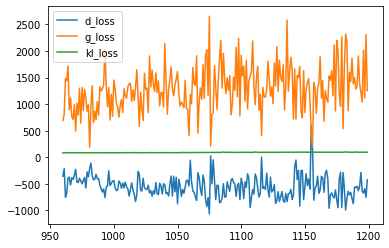

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

for i in range(4, 5):
  log = pd.read_csv('/content/gdrive/MyDrive/major/training_runs/2/losses/loss_{}.log'.format(i), delimiter='\t', header=None, names=['d_loss', 'g_loss', 'kl_loss'])
  n = len(log.d_loss)
  xs = list(range(n*i, n*(i + 1)))
  plt.plot(xs, log.d_loss)
  plt.plot(xs, log.g_loss)
  plt.plot(xs, log.kl_loss)
  plt.legend(log.columns)

In [ ]:
from networks.ConditionAugmentation import ConditionAugmentor
from pro_gan_pytorch.PRO_GAN import ConditionalProGAN

import numpy as np

def create_grid(samples, scale_factor, img_file, real_imgs=False):
    """
    utility function to create a grid of GAN samples
    :param samples: generated samples for storing
    :param scale_factor: factor for upscaling the image
    :param img_file: name of file to write
    :param real_imgs: turn off the scaling of images
    :return: None (saves a file)
    """
    from torchvision.utils import save_image
    from torch.nn.functional import interpolate

    samples = th.clamp((samples / 2) + 0.5, min=0, max=1)

    # upsample the image
    if not real_imgs and scale_factor > 1:
        samples = interpolate(samples,
                              scale_factor=scale_factor)

    # save the images:
    save_image(samples, img_file, nrow=int(np.sqrt(len(samples))))

In [ ]:
# create the networks

condition_augmenter = ConditionAugmentor(
    input_size=config.hidden_size,
    latent_size=config.ca_out_size,
    use_eql=config.use_eql,
    device=device
)

ca_file = '/content/gdrive/MyDrive/major/training_runs/2/saved_models/Condition_Augmentor_4.pth'

print("Loading conditioning augmenter from:", ca_file)
condition_augmenter.load_state_dict(th.load(ca_file))

c_pro_gan = ConditionalProGAN(
    embedding_size=config.hidden_size,
    depth=config.depth,
    latent_size=config.latent_size,
    compressed_latent_size=config.compressed_latent_size,
    learning_rate=config.learning_rate,
    beta_1=config.beta_1,
    beta_2=config.beta_2,
    eps=config.eps,
    drift=config.drift,
    n_critic=config.n_critic,
    use_eql=config.use_eql,
    loss=config.loss_function,
    use_ema=config.use_ema,
    ema_decay=config.ema_decay,
    device=device
)

generator_file = '/content/gdrive/MyDrive/major/training_runs/2/saved_models/GAN_GEN_4.pth'
print("Loading generator from:", generator_file)
c_pro_gan.gen.load_state_dict(th.load(generator_file))

Loading conditioning augmenter from: /content/gdrive/MyDrive/major/training_runs/2/saved_models/Condition_Augmentor_4.pth
Loading generator from: /content/gdrive/MyDrive/major/training_runs/2/saved_models/GAN_GEN_4.pth


In [ ]:
condition_augmenter.train(False)

ConditionAugmentor(
  (transformer): _equalized_linear()
)

In [ ]:
temp_data = dl.get_data_loader(dataset, 1, num_workers=3)
fixed_captions, fixed_real_images = iter(temp_data).next()

In [ ]:
str = input('Enter your caption : ')

Enter your caption : a male in his 3 0 s , white and clean shaven with dar k hair and eyebrows .


In [ ]:
fixed_caption = (str,)
fixed_captions = fixed_caption

In [ ]:
fixed_embeddings = text_encoder(fixed_captions)
fixed_embeddings = th.from_numpy(fixed_embeddings).to(device)

fixed_c_not_hats, mus, _ = condition_augmenter(fixed_embeddings)

fixed_noise = th.zeros(len(fixed_captions),
                       c_pro_gan.latent_size - fixed_c_not_hats.shape[-1]).to(device)

fixed_gan_input = th.cat((fixed_c_not_hats, fixed_noise), dim=-1)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


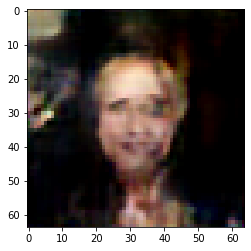

In [ ]:
create_grid(
    samples=c_pro_gan.gen(
        fixed_gan_input,
        4,
        1.0
    ),
    scale_factor=1,
    img_file='output.png')

img = plt.imread('output.png')
plt.figure()
plt.imshow(img)

In [ ]:
fixed_captions

('a male in his 3 0 s , white and clean shaven with dar k hair and eyebrows .',)